# Translating multiomics single-cell data

In this tutorial, we showcase the use of the {class}`~moscot.problems.cross_modality.TranslationProblem`, as outlined in {cite}`demetci-scot:22`, to integrate different modalities of single-cell data. In particular, we compute a mapping to translate **chromatin accessibility** (ATAC) and **gene expression** (RNA).

## The method
The {class}`~moscot.problems.cross_modality.TranslationProblem` uses Fused Gromov-Wasserstein (FGW) {cite}`vayer:2020`, a type of Optimal Transport (OT), for computing cell-to-cell correspondence probabilities between multiomics single-cell data. As input data, we consider a [Latent Semantic Indexing (LSI)](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.lsi.html) embedding for the ATAC data and a [Principal Component Analysis (PCA)](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.pca.html) embedding of the RNA. Since these distinct feature spaces are not directly comparable, we employ a quadratic **Gromov-Wasserstein** (GW) {cite}`nitzan:19,peyre:2016` term that compares pairwise ATAC and RNA cells and seeks to preserve some local geometry between similar cells. Additionally, we may include a linear **Wasserstein** (W) term that contains a [scVI integration](https://scvi-tools.org) of the gene expression raw counts of the RNA and the gene activity raw counts of the ATAC data. Leaving out the linear term makes this a pure GW problem.

Additionally, we use entropic regularization {cite}`cuturi:2013` to speed up computations and to improve the statistical properties of the solution {cite}`peyre:19`. In the objective function, we compare $N$ source (here ATAC) to $M$ target (here RNA) cells. We use the following definitions: 

- $P \in \mathbb{R}^{N \times M}$: coupling matrix we seek to learn; it probabilistically relates source to target cells. 
- $C^X$ and $C^Y$: cost matrices among source and target cells, respectively. These quantify similarity among cells from one modality. 
- $C$: cost matrix between source and target cells in a common feature space; it quantifies how "expensive" it is to move along the phenotypic landscape. Typically, it represents Euclidean distance in a gene expression-based latent space like PCA or scVI {cite}`lopez2018deep`. 
- $H(P)$: entropy of the coupling matrix {cite}`cuturi:2013`. 
- $\varepsilon$: weight given to entropic regularitation. Larger values will lead to more "blurred" couplings. 
- $\alpha$: weight given to W (joint features) vs. GW (distinct features) terms.

## Preliminaries

In [1]:
import warnings

from moscot import datasets
import moscot.plotting as mpl
from moscot.problems.cross_modality import TranslationProblem

import scanpy as sc
import anndata as ad
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing as pp

warnings.simplefilter("ignore", [UserWarning])

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Define utility functions
We will use the average FOSCTTM measure implemented below for evaluation (metric used in {cite}`demetci-scot:22`). This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples (the smaller the better).

In [2]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i]+foscttm_y[i])/2)
    return np.mean(fracs).round(4)

### Dataset description
This dataset contains preprocessed bone marrow mononuclear cell data from the [Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2021](https://openproblems.bio/competitions/neurips_2021_docs/data/dataset.html). The samples were measured using the [10X Multiome Gene Expression and Chromatin Accessibility kit](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression). 

Within the {func}`~moscot.datasets.bone_marrow` dataset, we store two [anndata](https://anndata.readthedocs.io/en/latest/) objects for the Site 1, Donor 1 ATAC and RNA data. The dataset includes the LSI and PCA embedding of ATAC and RNA respectively, as well as the scVI integration of gene expression and gene activity.

### Data loading
We download the data from figshare (approx 43MB).

In [3]:
adata_atac = datasets.bone_marrow(rna=False, force_download=True)
adata_rna = datasets.bone_marrow(rna=True, force_download=True)
adata_atac, adata_rna

100%|██████████| 16.9M/16.9M [00:03<00:00, 4.82MB/s]
100%|██████████| 25.5M/25.5M [00:11<00:00, 2.43MB/s]


(AnnData object with n_obs × n_vars = 6224 × 8000
     obs: 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 6224 × 2000
     obs: 'GEX_n_counts', 'GEX_n_genes', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'GEX_X_pca', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances')

### Preprocessing
Basic preprocessing to obtain a l2-normalization of the ATAC data using [`sklearn.preprocessing.normalize`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

In [4]:
adata_atac.obsm['ATAC_lsi_l2_norm'] = pp.normalize(adata_atac.obsm['ATAC_lsi_full'], norm='l2')

### Visualization
Let’s take a look at the ATAC and RNA data by plotting a UMAP of the respective domain before the alignment, colored according to cell type.

TypeError: issubclass() arg 2 must be a class or tuple of classes

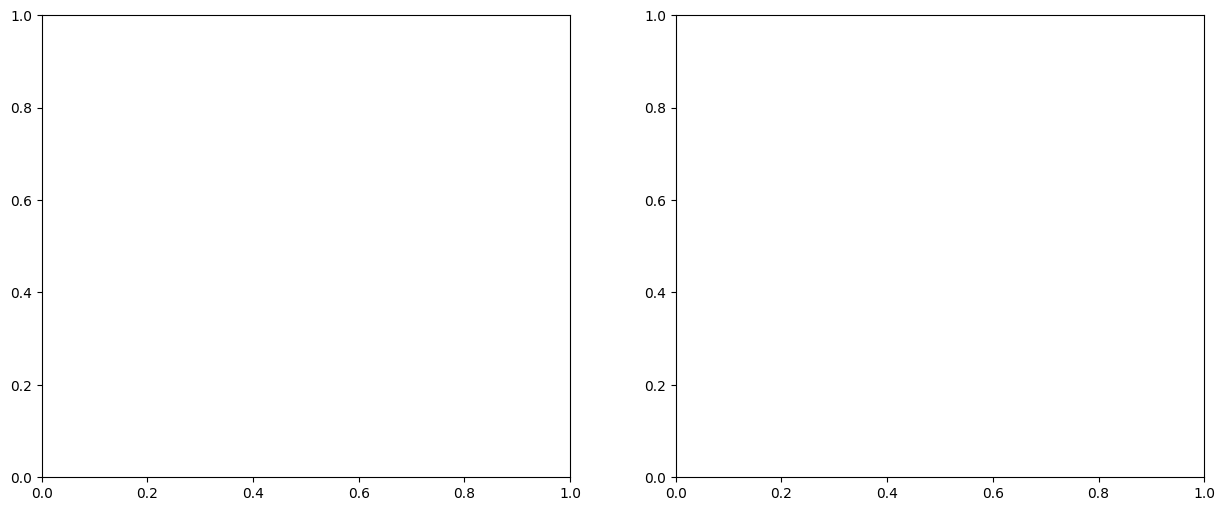

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color='cell_type', ax=ax1, show = False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color='cell_type', ax=ax2, show = False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [7]:
sc.pl.umap(adata_atac, color='cell_type')

TypeError: issubclass() arg 2 must be a class or tuple of classes

## Prepare the {class}`~moscot.problems.cross_modality.TranslationProblem`

We need to initialize the {class}`~moscot.problems.cross_modality.TranslationProblem` by passing the source and target {class}`~anndata.AnnData` objects. After initialization, we need to {meth}`~moscot.problems.cross_modality.TranslationProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `src_attr`: specifies the attribute in {class}`~anndata.AnnData` that contains the source distribution. In our case it refers to the key in {attr}`~anndata.AnnData.obsm`
that stores the ATAC LSI embedding.
- `tgt_attr`: specifies the attribute in {class}`~anndata.AnnData` that contains the target distribution. In our case it refers to the key in {attr}`~anndata.AnnData.obsm`
that stores the RNA PCA embedding.
- `joint_attr`[optional]: specifies a joint attribute over a common feature space to incorporate a linear term into the quadratic optimization problem. Initially, we consider the pure Gromov-Wasserstein setting and subsequently explore the fused problem.

In [ ]:
tp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
tp = tp.prepare(
    src_attr="ATAC_lsi_l2_norm",
    tgt_attr="GEX_X_pca"
)

## Solve the {class}`~moscot.problems.cross_modality.TranslationProblem`
In fused quadratic problems, the `alpha` parameter defines the convex combination between the quadratic and linear terms. By default, `alpha = 1`, that is, we only consider the quadratic problem, ignoring the `joint_attr`. We choose a small value for `epsilon` to obtain a sparse transport map.

In [ ]:
tp = tp.solve(alpha=1.0, epsilon=1e-3)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


## Translate the {class}`~moscot.problems.cross_modality.TranslationProblem`
We can now project one domain onto the other. The boolean parameter `forward` determines the direction of the barycentric projection. In our case, we project the source distribution {class}`~anndata.AnnData` (`ATAC`) onto the target distribution {class}`~anndata.AnnData` (`RNA`), therefore we use `forward = True`. The function {meth}`~moscot.problems.cross_modality.TranslationProblem.translate` returns the translated object in the target space (or source space respectively).

In [ ]:
translated = tp.translate(
    source='src', 
    target='tgt', 
    forward=True
)

## Analyzing the translation
We will use the average FOSCTTM metric implemented above to analyze the alignment performance.

In [7]:
print("Average FOSCTTM score of translating ATAC onto RNA: ", foscttm(adata_rna.obsm['GEX_X_pca'], translated))

NameError: name 'translated' is not defined

For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to the gene expression PCA domain to the original gene expression PCA data. Then we plot a UMAP of the concatenated data in the gene expression domain, colored according to the original domain and cell type.

In [9]:
adata = sc.concat([adata_atac, adata_rna], join = 'outer', label='batch', keys=["ATAC (translated)", "RNA"])
adata.obsm['X_translated_1'] = np.concatenate((translated, adata_rna.obsm['GEX_X_pca']), axis = 0)
sc.pp.neighbors(adata, use_rep = 'X_translated_1')
sc.tl.umap(adata)

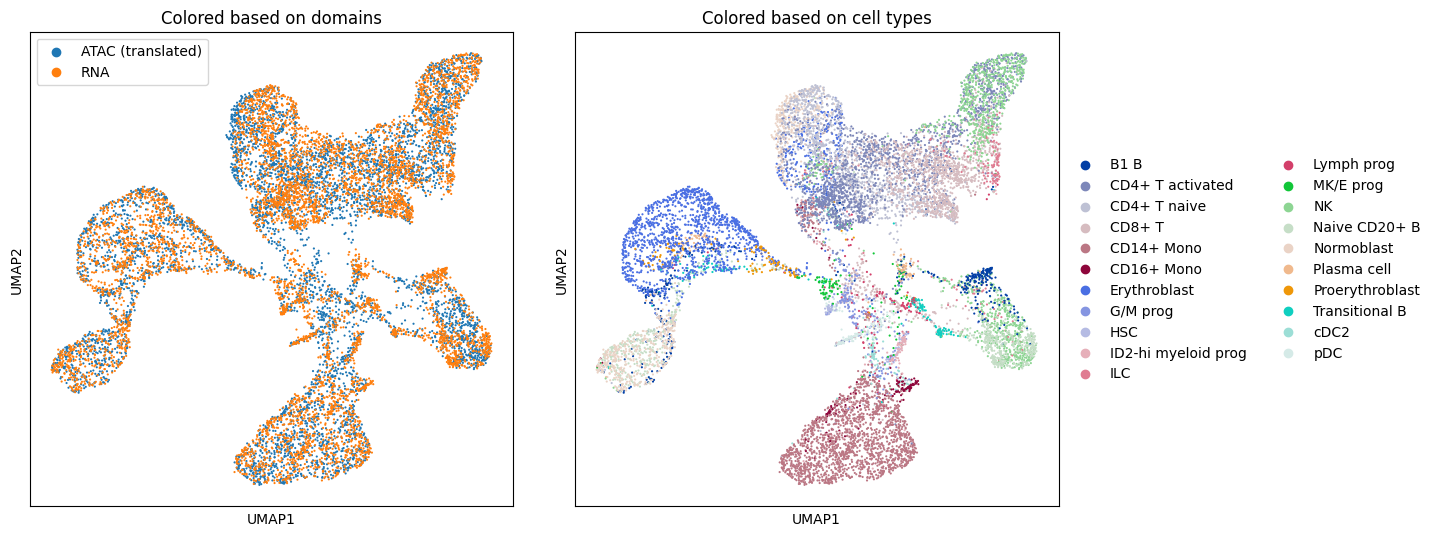

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color = ['batch'], ax=ax1, show = False)
ax1.legend()
ax1.set_title("Colored based on domains")
sc.pl.umap(adata, color = ['cell_type'], ax=ax2, show = False)
#ax2.legend()
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

## Extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to the fused setting
We proceed to extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to incorporate the fused setting. In this regard, we aim to evaluate the potential benefits of augmenting the quadratic problem with a linear term. Therefore, we {meth}`~moscot.problems.space.MappingProblem.prepare` a new problem, by employing a scVI integration of the gene activity data in the `joint_attr`. Then, we {meth}`~moscot.problems.cross_modality.TranslationProblem.solve` the resulting problem, with `alpha=0.9` and the epsilon parameter identical to that used in the pure Gromov-Wasserstein case.

In [7]:
ftp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm",
    tgt_attr="GEX_X_pca",
    joint_attr = 'geneactivity_scvi'
)
ftp = ftp.solve(epsilon=1e-3, alpha=0.9)
translated_fused = ftp.translate(source='src', target='tgt', forward=True)
print("Average FOSCTTM score for translating ATAC onto RNA: ", foscttm(adata_rna.obsm['GEX_X_pca'], translated_fused))

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          
Average FOSCTTM score for translating ATAC onto RNA:  0.1015


The experimental results demonstrate a significant improvement in the fused setting when compared to the pure Gromov-Wasserstein case.

### Visualize translation

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


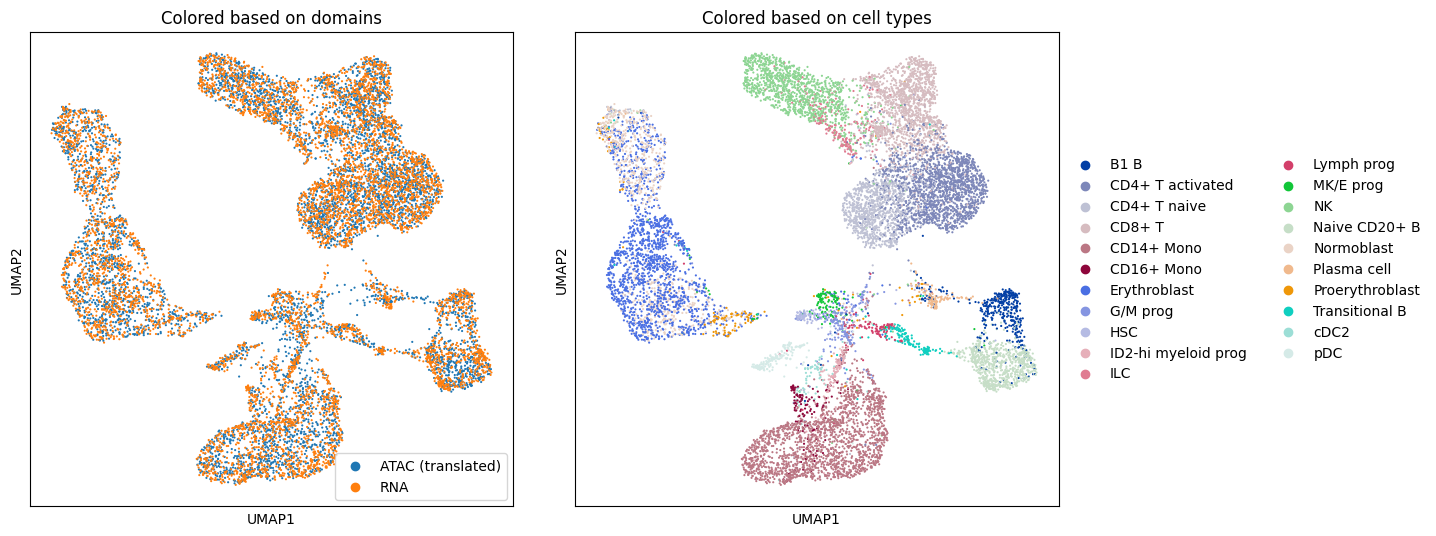

In [10]:
adata.obsm['X_translated_2'] = np.concatenate((translated_fused, adata_rna.obsm['GEX_X_pca']), axis = 0)
sc.pp.neighbors(adata, use_rep = 'X_translated_2')
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color = ['batch'], ax=ax1, show = False)
ax1.legend()
ax1.set_title("Colored based on domains")
sc.pl.umap(adata, color = ['cell_type'], ax=ax2, show = False)
#ax2.legend()
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing cell type transitions
The cell type transition matrix provides a mapping of cell types from one modality to another and can be used to examine the correspondence between cell types across different datasets. The resulting matrix illustrates which cell types are mapped where thereby enabling further downstream analyses. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

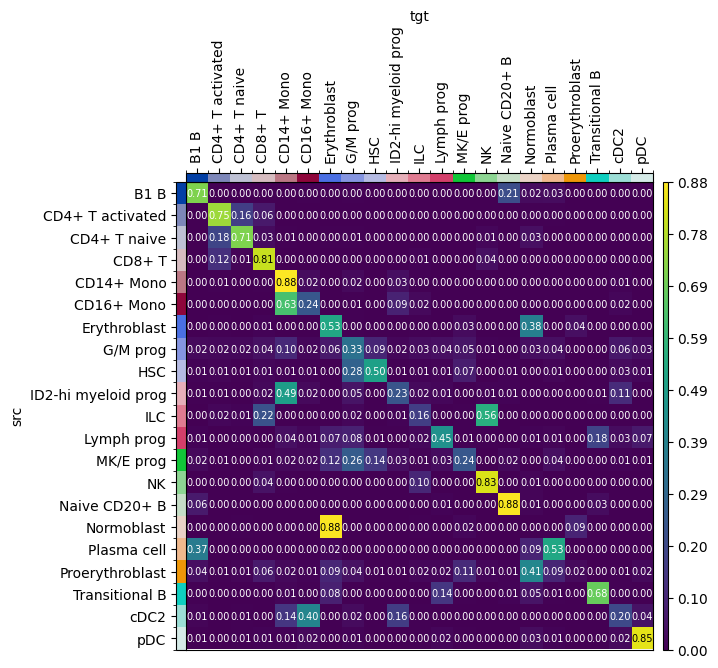

In [11]:
order = adata_atac.obs['cell_type'].cat.categories

cell_transition = ftp.cell_transition(
    source='src',
    target='tgt',
    source_groups={"cell_type": order},
    target_groups={"cell_type": order},
    forward=True,
    key_added="ftp_transitions",
)

mpl.cell_transition(ftp, figsize=(5, 5), uns_key="ftp_transitions")

The rows sum up to 1, as for each cell type in a certain row, the columns indicate where the cells are translated to. For example, Erythroblast cells are mainly mapped to Erythroblast cells in 53/100 cases, while a considerable number are also mapped to Normoblast cells. In contrast, CD14+ Mono cells are mapped to CD14+ Mono cells.